# Chatbot con Red Neuronal Sequential (Keras)

Librerías necesarias:

In [1]:
## Librerías:
# ... Para 'intents.json'
import json # Para el formato json
import codecs # Lectura de caracteres en español (tildes y 'ñ')
# ... Procesamiento de Lenguaje Natural
import spacy # Lemmatizer (convertir palabras) con lenguaje español
import pickle # Guardar archivos
import numpy as np 
import nltk # Natural Language ToolKit: Tokenizar
from recursos import lemmatizer, normalize_tilde

Para crear la Red Neuronal Secuencial con Keras:

In [2]:
# Redes Neuronales:
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD

## Estudiar el Chatbot

Cargar el modelo de Red Neuronal:

In [3]:
from tensorflow.keras.models import load_model

model = load_model('chatbot_model.model')
words = pickle.load(open('words.pkl','rb'))
tags = pickle.load(open('tags.pkl','rb'))
print(tags)

['consulta_categoria', 'consulta_funciones', 'consulta_lugar', 'consulta_lugares_cerca', 'consulta_precio', 'consulta_recomendacion', 'consulta_tiempo', 'consulta_trivia', 'contexto', 'despedida', 'gracias', 'nulo', 'saludos']


Funciones para la representación de Bag of Words.

Estas funciones son las mismas que se usan en chatbot.py

In [4]:
def clean_up_sentence(sentence):
    """
    Limpiar oración de entrada (lematizar cada palabra)
    """
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer(word) for word in sentence_words]
    return sentence_words

def bag_of_words(sentence):
    """
    Convertir la oración de entrada a bag_of_words
    """
    sentence_words = clean_up_sentence(sentence)
    # sentence_words: Arreglo de las palabras lematizadas
    bag = [0] * len(words)
    # bag: Arreglo de 0s
    for w in sentence_words:
        for i, word in enumerate(words):
            if word == w:
                bag[i] = 1
                # Cambiar a '1' donde haya incidencia (bag of words)
    return np.array(bag)

### Conjunto de datos de prueba

In [5]:
test_intents = json.loads(codecs.open('test_intents.json', encoding='utf-8').read())

X_test = []
Y_test_array = []
Y_test_tagged = []

for intent in test_intents['intents']:
    for pattern in intent['patterns']:
        pattern = lemmatizer(pattern.lower())
        bow = bag_of_words(pattern)
        X_test.append(bow)
        Y_test_tagged.append(intent['tag'])
        
        output_row = list([0 for i in range(len(tags))]) # Hacer una lista de 0, del tamaño de len(tags)
        output_row[tags.index(intent['tag'])] = 1 # Cambia a '1' la celda de mismo índice que tag en tags.
        Y_test_array.append(output_row)

#print("X:")  
#print(X_test[:2])
#print("Y:")
#print(Y_test_array[:5])
#print("Y:")
#print(Y_test_tagged[:5])

In [36]:
def make_predict(bow):
    """
    * bow: Arreglo representación Bag of Words
    """
    res = model.predict(np.array([bow]))[0] # Recibe el resultado del modelo, recibiendo como entrada 'bow' (ver línea de arriba, 45)
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    # Si 'resultado' es mayor que el umbral, entonces considera el par [indice del 'resultado', 'resultado']
    results.sort(key=lambda x: x[1], reverse=True)
    # Ordenar resultados según la mayor probabilidad (Softmax como capa de salida)
    y_pred = [0 for _ in range(len(tags))]
    y_pred[results[0][0]] = 1
    # return (Tag en lista booleana), (Tag en string), Probabilidad del resultado
    return list(y_pred), tags[results[0][0]], results[0][1]

y_pred_array = []
y_pred_tags = []
y_pred_prob = []
for sentence_bow in X_test:
    pred, tag, prob = make_predict(sentence_bow)
    y_pred_array.append(pred)
    y_pred_tags.append(tag)
    y_pred_prob.append(prob)

In [38]:
print("Pred:")
print(y_pred_array[:5])
print(y_pred_tags[:5])
print(y_pred_prob[:5])
print("Test:")
print(Y_test_tagged[:5])

Pred:
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
['saludos', 'saludos', 'saludos', 'saludos', 'saludos']
[0.99998784, 0.9999316, 0.9998149, 0.97717583, 0.99897873]
Test:
['saludos', 'saludos', 'saludos', 'saludos', 'saludos']


In [39]:
print(" ".ljust(25,' ') + " Reales \t Predicho")
for tag in tags:
    aux = tag.ljust(25, ' ')
    aux += " %s \t \t %s"%(Y_test_tagged.count(tag),y_pred_tags.count(tag))
    print(aux)

                          Reales 	 Predicho
consulta_categoria        8 	 	 8
consulta_funciones        12 	 	 11
consulta_lugar            22 	 	 16
consulta_lugares_cerca    10 	 	 10
consulta_precio           13 	 	 16
consulta_recomendacion    13 	 	 13
consulta_tiempo           16 	 	 14
consulta_trivia           15 	 	 17
contexto                  12 	 	 11
despedida                 18 	 	 17
gracias                   9 	 	 9
nulo                      1 	 	 6
saludos                   22 	 	 23


### Matriz de confusión

Podemos calcular las 13 matrices de confusión binarias para cada categoría

In [40]:
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(Y_test_array, y_pred_array)

for i in range(len(tags)):
    print(tags[i])
    print(pd.DataFrame(mcm[i],
                       index = list(['Falso (realmente)', 'Verdadero (realmente)']), 
                       columns = list(['Falso (predicho)', 'Verdadero (predicho)'])))
    print("-".ljust(65,'-'))

consulta_categoria
                       Falso (predicho)  Verdadero (predicho)
Falso (realmente)                   162                     1
Verdadero (realmente)                 1                     7
-----------------------------------------------------------------
consulta_funciones
                       Falso (predicho)  Verdadero (predicho)
Falso (realmente)                   159                     0
Verdadero (realmente)                 1                    11
-----------------------------------------------------------------
consulta_lugar
                       Falso (predicho)  Verdadero (predicho)
Falso (realmente)                   148                     1
Verdadero (realmente)                 7                    15
-----------------------------------------------------------------
consulta_lugares_cerca
                       Falso (predicho)  Verdadero (predicho)
Falso (realmente)                   161                     0
Verdadero (realmente)                 0     

También podemos ver una matriz de confusión multicategórica que consolide esta información:

In [41]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(Y_test_tagged, y_pred_tags)
print("Matriz de Confusión:")
cm_df_freq = pd.DataFrame(cm,
                     index = list(tags), 
                     columns = list(tags))
cm_df_freq

Matriz de Confusión:


,consulta_categoria,consulta_funciones,consulta_lugar,consulta_lugares_cerca,consulta_precio,consulta_recomendacion,consulta_tiempo,consulta_trivia,contexto,despedida,gracias,nulo,saludos
consulta_categoria,7,0,0,0,0,0,0,0,0,0,0,0,1
consulta_funciones,0,11,0,0,0,0,0,0,0,0,0,0,1
consulta_lugar,0,0,15,0,3,0,0,2,0,0,0,2,0
consulta_lugares_cerca,0,0,0,10,0,0,0,0,0,0,0,0,0
consulta_precio,0,0,0,0,13,0,0,0,0,0,0,0,0
consulta_recomendacion,0,0,0,0,0,12,0,0,0,0,0,1,0
consulta_tiempo,0,0,1,0,0,1,14,0,0,0,0,0,0
consulta_trivia,0,0,0,0,0,0,0,15,0,0,0,0,0
contexto,1,0,0,0,0,0,0,0,11,0,0,0,0
despedida,0,0,0,0,0,0,0,0,0,17,0,1,0


En la matriz de confusión multicategórica, las filas son la categorías reales; y las columnas son las categorías predichas.

De esta manera, si definimos:

* $tags$: Arreglo que contiene las $n$ categorías que caracterizan las posibles intenciones del usuario mapeadas.
> * $tags = [tag_0, tag_1, \dots, tag_n]$

Para obtener estos resultados se usaron dos arreglos paralelos:
* $Y_{test} = [tag(X_{test_0}), tag(X_{test_1}), \dots, tag(X_{test_N})]$
* $Y_{pred} = [pred(X_{test_0}), pred(X_{test_1}), \dots, pred(X_{test_N})]$

Donde $N$ es el número de instancias en la matriz de datos de test $X_{test}$, la función $tag(x)$ es la etiqueta real de la instancia $x$; y $pred(x)$ es la etiqueta predicha por la red neuronal al tomar como entrada $x$.

Para comparar ambos arreglos podemos definir el conteo:


> $conteo(Y_{test}, Y_{pred}, tag_{i}, tag_{j}):$
> 1. $res = 0$
> 2. para $k$ en el rango de $[0, N]$:
> > si ($Y_{test} == tag_i$ y $Y_{pred} == tag_j$):
> > * $res = res + 1$
> 3. Retornar $res$

Es decir, la función cuenta el número de instancias donde se cumple que $Y_{test_k} = tag_{i}$ y $Y_{pred_k} = tag_{j}$ para un iterador $k$ en el rango de $0$ hasta $N$.

Entonces, para cada celda de la matriz de confusión $cm$, de dimensiones $n \times n$, se cumple:
> $cm_{i, j} = conteo(Y_{test}, Y_{pred}, tag_{i}, tag_{j})$

In [42]:
def normalizar_matriz(matriz):
    row_sums = matriz.sum(axis=1)
    new_matrix = matriz / row_sums[:, np.newaxis]
    new_matrix = np.array([[round(c,2) for c in row] for row in new_matrix]) 
    return new_matrix

normal_cm = normalizar_matriz(cm)
print("Matriz Normalizada:")
cm_df = pd.DataFrame(normal_cm,
                     index = list(tags), 
                     columns = list(tags))
cm_df

Matriz Normalizada:


,consulta_categoria,consulta_funciones,consulta_lugar,consulta_lugares_cerca,consulta_precio,consulta_recomendacion,consulta_tiempo,consulta_trivia,contexto,despedida,gracias,nulo,saludos
consulta_categoria,0.88,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.12
consulta_funciones,0.00,0.92,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.08
consulta_lugar,0.00,0.00,0.68,0.0,0.14,0.00,0.00,0.09,0.00,0.00,0.0,0.09,0.00
consulta_lugares_cerca,0.00,0.00,0.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
consulta_precio,0.00,0.00,0.00,0.0,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
consulta_recomendacion,0.00,0.00,0.00,0.0,0.00,0.92,0.00,0.00,0.00,0.00,0.0,0.08,0.00
consulta_tiempo,0.00,0.00,0.06,0.0,0.00,0.06,0.88,0.00,0.00,0.00,0.0,0.00,0.00
consulta_trivia,0.00,0.00,0.00,0.0,0.00,0.00,0.00,1.00,0.00,0.00,0.0,0.00,0.00
contexto,0.08,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.92,0.00,0.0,0.00,0.00
despedida,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.94,0.0,0.06,0.00


Cada celda de la matriz de confusión normalizada $ncm$ proviene del cálculo: 
* $ncm_{i,j} = \frac{cm{i,j}}{\sum_k^n{cm_{i, k}}}$

Es decir, cada celda $m_{i,j}$ de la matriz normalizada es la proporción $\frac{n(Y_{test\ con\ tag\ i} \cap Y_{pred\ con\ tag\ j})}{n(Y_{test\ con\ tag\ i})}$

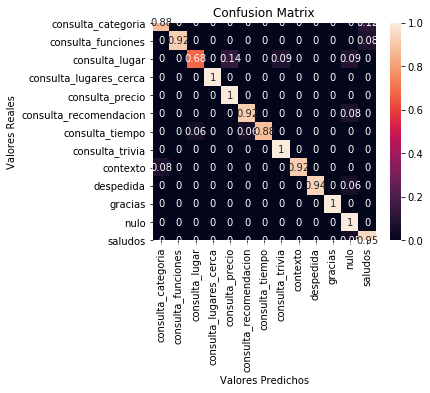

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

Entre los resultados, destaca la tasa de verdaderos positivos del modelo con la categoría $consulta\_lugar$, con $0.68$. Esto quiere decir, que de todas las oraciones con intención de consultar por la dirección del lugar, la red neuronal solo identifica correctamente el $68\%$

### Curva ROC

A partir de las métricas $TPR$ (*True positive rate*, o *tasa de verdaderos positivos*) y $FPR$ (*Tasa de falsos positivos*), se puede construir una curva ROC.

* $TPR = \frac{Verdaderos\ Positivos}{Verdaderos\ Positivos + Falsos\ Negativos}$
* $FPR = \frac{Falsos\ Positivos}{Falsos\ Positivos + Verdaderos\ Positivos}$

Entonces, podemos calcular puntualmente estas métricas por categoría:

In [64]:
# Matriz es:
# ............Pred F ......... | ... Pred T
# Real F  Verdaderos Negativos | Falsos Positivos
# Real T  Falsos Negativos     | Verdaderos Positivos
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

metricas_names = ['tag', 'TPR', 'FPR', 'Precision', 'Recall', 'Accuracy']

metricas = []
for i, m in enumerate(mcm):
    TP = m[1][1] # True Positive
    TN = m[0][0] # True Negatives
    FN = m[1][0] # False Negatives
    FP = m[0][1] # False Positives
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    metricas.append([tags[i], round(tpr,5),round(fpr,5), round(precision,5), round(recall,5), accuracy])
    #aux = tags[i].ljust(25,' ') + str(round(tpr,3)).ljust(10,' ') + str(round(fpr,3)).ljust(10,' ')
    #print(aux)
metricas = np.array(metricas)    
pd.DataFrame(metricas, columns=metricas_names)

,tag,TPR,FPR,Precision,Recall,Accuracy
0,consulta_categoria,0.875,0.125,0.875,0.875,0.9883040935672515
1,consulta_funciones,0.91667,0.0,1.0,0.91667,0.9941520467836257
2,consulta_lugar,0.68182,0.0625,0.9375,0.68182,0.9532163742690059
3,consulta_lugares_cerca,1.0,0.0,1.0,1.0,1.0
4,consulta_precio,1.0,0.1875,0.8125,1.0,0.9824561403508771
5,consulta_recomendacion,0.92308,0.07692,0.92308,0.92308,0.9883040935672515
6,consulta_tiempo,0.875,0.0,1.0,0.875,0.9883040935672515
7,consulta_trivia,1.0,0.11765,0.88235,1.0,0.9883040935672515
8,contexto,0.91667,0.0,1.0,0.91667,0.9941520467836257
9,despedida,0.94444,0.0,1.0,0.94444,0.9941520467836257


In [57]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

roc_aux = []
for tag in tags:
    aux_y_test = [1 if y == tag else 0 for y in Y_test_tagged]
    aux_y_pred = [1 if y == tag else 0 for y in y_pred_tags]
   
    for i in range(len(aux_y_pred)):
        if aux_y_pred[i] == 1:
            aux_y_pred[i] = y_pred_prob[i]
        else:
            aux_y_pred[i] = (1 - y_pred_prob[i])
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(aux_y_test, aux_y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    roc_aux.append([false_positive_rate, true_positive_rate, roc_auc])

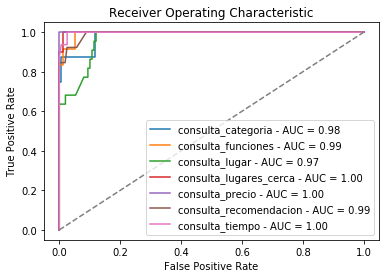

In [58]:
plt.title('Receiver Operating Characteristic')
for i, aux in enumerate(roc_aux[:7]):
    plt.plot(aux[0], aux[1], label = "%s - AUC = %0.2f"%(tags[i], aux[2]))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()